In [1]:
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load the results per survey

In [2]:
survey = 'PanStarrs'
# survey = 'Gaia'
# survey = 'ZTF'
results_rnn = glob('../04_ComputeMetrics/{}/Results/*'.format(survey))
results_rnn.sort()
# results_rnn

In [3]:
results_rf = glob('../../../../../../BRF_baseline/experiments/regression/{}/results/*'.format(survey))
results_rf.sort()
# results_rf

In [4]:
r1 = pd.read_csv(results_rnn[0])
r2 = pd.read_csv(results_rf[1], index_col='oid')
# r2.index = r2.index.astype(int)
r1.head()

,Prob_RRC,Prob_T2CEP,Prob_RRD,Prob_MIRA_SR,Prob_RRAB,Prob_DSCT_SXPHE,Class,Pred,True_T_eff,Pred_T_eff,True_Radius,Pred_Radius
84300158481827892,0.963807,0.000158,0.031980,0.000004,0.003961,9.083281e-05,RRC,RRC,7396.3037,7270.9070,-1.0,13.418306
74163190788076994,0.000019,0.000030,0.000358,0.000002,0.999572,1.841904e-05,RRAB,RRAB,5955.7760,6234.9897,-1.0,8.359905
103253008374854869,0.999497,0.000019,0.000256,0.000016,0.000117,9.621263e-05,RRC,RRC,6638.7150,5767.8823,-1.0,13.194317
74022884304620926,0.971100,0.000107,0.012762,0.000005,0.015969,5.726083e-05,RRC,RRC,7203.6280,6730.8330,-1.0,13.048449
131542740608734400,0.030366,0.000120,0.001657,0.000005,0.967851,3.914358e-07,RRAB,RRAB,6253.8680,5624.9033,-1.0,8.247026


In [5]:
r2.head()

,True_T_eff,Pred_T_eff
oid,,
90752870729198448,6033.0000,6486.762386
111850650934828512,6731.0000,6398.102026
115542702349595216,5990.3335,6648.945406
74652707998828064,4777.0000,5184.024537
108932907287826784,3850.7400,4022.193163


In [6]:
# r1.loc[111850650934828512]
r2.loc[111850650934828512]
r2[r2['True_T_eff']==6731 	]

,True_T_eff,Pred_T_eff
oid,,
111850650934828512,6731.0,6398.102026
103652947060150512,6731.0,5806.212683
91252550060170240,6731.0,5482.591614


In [7]:
# pd.merge(r1,r2, left_index=True, right_index=True)

In [8]:
s1 = set(r1.index)

In [9]:
s2 = set(r2.index)

In [10]:
len(s1.intersection(s2))

218

In [4]:
def split_experiments(results):
    """Split the experiments for each physical parameter."""

    # Use th efirst fold as a guide
    res = [result for result in results if "Fold_1" in result]
    # Get the different physical parameters
    # First select the filename
    params_files = [i.split('/')[-1] for i in res]
    # Then find "Fold_1_" and select everything after that
    params = [i.partition('Fold_1_')[2].split('.')[0] for i in params_files]
    # For each param, create a list. Keys are the params
    exp_lists = dict.fromkeys(params,[])
    for param in params:
        exp_lists[param] = [i for i in results if param in i]
        # Sort them to start from the first
        exp_lists[param].sort()
    return exp_lists, params


Estimate the median of each prediction

In [5]:
def get_cols(df, params):
    """Extracts the pred and true physical parameters."""
    # Columns containing the relevant information
    cols = ['Pred_','True_']
    df = df[[p+i for i in params for p in cols]]
    return df

In [6]:
def check_index(df, index_name):
    """Check if the index is index_name, if it is not, assigns it."""
    
    # Check if oid is one of the columns
    if index_name in df.columns:
        # Change the index to be an int
        df[index_name] = df[index_name].astype(int)
        # Set is as the index
        df = df.set_index(index_name)
    return df
def prepare_files(results, index_name='oid'):
    # Read the first DataFrame to include data here
    dfs = pd.read_csv(results[0])
    # Checks index
    dfs = check_index(dfs, index_name)    
    # Get the column names
    columns = dfs.columns
    # Only extract the columns with physical parameters
    params = ['_'.join(i.split('_')[1:]) for i in columns if 'Pred_' in i]
    # Get the true and predicted values
    dfs = get_cols(dfs, params)
    # only get the predictions
    sel_params = ['Pred_'+param for param in params]
    # Iterate over all the folds to create a single dataframe
    for i,result in enumerate(results[1:], start=1):
        # reads the data, assumes index is written
        df = pd.read_csv(result)
        # Checks index
        df = check_index(df, index_name)
        df = get_cols(df, params)
        dfs = pd.merge(dfs, df[sel_params], how='inner', left_index=True, right_index=True,suffixes=('','_'+str(i)))    
    return dfs, params


In [7]:
def get_results(results_list, from_rf=False):

    # process the files for the RF
    if from_rf:
        # Extract each physical parameter's result
        results_rf, params = split_experiments(results_list)
        # Process each one individually
        # Start with the first one
        dfs,_ = prepare_files(results_rf[params[0]])
        for param in params[1:]:
            # Get the param, ignore the second output (same param)
            df,_ = prepare_files(results_rf[param])
            dfs = dfs.merge(df, left_index=True, right_index=True)
        # Join them, column wise (axis1)
        # dfs = 
    else:
        # Process the files for the rnn
        dfs,params = prepare_files(results_list)
    # Compute the median and mean, per parameter
    output_df = dfs[[i for i in dfs.columns if 'True_' in i]].copy()
    for param in params:
        # Select only the predicted columns
        pred_cols_param = [col for col in dfs.columns if 'Pred_'+param in col]
        sel = dfs[pred_cols_param]
        # Get the statistics
        median = sel.median(axis=1)
        mean = sel.mean(axis=1)
        # Output the dataframe
        output_df = output_df.assign(**{'median_'+param:median ,
                                        'mean_'+param: mean})
    return output_df
# output_df.head()

In [8]:
get_results(results_rf, from_rf=True)

,True_Radius,True_T_eff,median_Radius,mean_Radius,median_T_eff,mean_T_eff
oid,,,,,,
90752870729198432,2.597,6033.0000,3.4288,5.639790,6406.855441,6407.440920
111850650934828512,0.708,6731.0000,2.4312,2.292457,6410.852162,6410.148500
115542702349595216,1.690,5990.3335,1.5458,1.736629,6672.229868,6671.597685
108932907287826784,50.880,3850.7400,41.6669,41.906342,3900.017086,3897.303279
87362697938833008,2.994,6684.0000,3.6101,3.582286,5527.718816,5527.414441
...,...,...,...,...,...,...
93772523605923024,4.306,4437.1700,4.4141,4.767100,5237.061054,5235.773915
128132569795921040,0.796,7845.0000,1.2291,1.238074,7604.517936,7604.990626
98022186269379488,5.655,6536.6470,2.1146,2.114543,6559.357362,6559.715118


In [9]:
get_results(results_rnn, from_rf=False)

,True_T_eff,True_Radius,median_T_eff,mean_T_eff,median_Radius,mean_Radius
84300158481827892,7396.3037,-1.0,7285.7590,7350.774300,2.986656,4.742947
74163190788076994,5955.7760,-1.0,6164.4080,6142.597514,11.409092,10.317746
103253008374854869,6638.7150,-1.0,5754.9253,5752.894414,11.474436,8.144556
74022884304620926,7203.6280,-1.0,6691.5337,6681.255014,2.368339,4.867855
131542740608734400,6253.8680,-1.0,5885.1260,5833.205900,8.247026,5.544814
...,...,...,...,...,...,...
88030993986271827,5179.1553,-1.0,5910.0730,5918.940929,10.607086,12.176787
74562631786708388,-1.0000,-1.0,5026.1370,5006.345029,30.169853,29.198549
121751335031127060,-1.0000,-1.0,7393.1060,7357.529657,1.632320,4.114735
98612894834983456,5699.5474,-1.0,5629.2485,5611.434000,15.067379,14.813931


## For  T_eff

In [42]:
# Extract results from rf and rnn
rnn = get_results(results_rnn, from_rf=False)
rf = get_results(results_rf, from_rf=True)

# Define the parameter
param = 'T_eff'
# param = 'Radius'
# Define the columns to read, for each param
true = 'True_'+param
mean= 'mean_'+param
median = 'median_'+param
# Select the output with measured values
rf_output = rf[[true, mean, median]][rf[true]>0].copy()
rnn_output = rnn[[true, mean, median]][rnn[true]>0].copy()

# Compute the absolute percent difference
perc_dif = lambda df : 100*np.abs(df[true]-df[median])/df[true]
rf_output['p_diff']=perc_dif(rf_output)
rnn_output['p_diff']=perc_dif(rnn_output)

# Create the bins based on the measured values
n_bins =15
param_range = rnn_output[true].max() - rnn_output[true].min()
bins = np.linspace(rnn_output[true].min(), rnn_output[true].max(), n_bins + 1)  # 21 edges to create 20 bins

# Find the middle point of each bin
mid_bins = [(bins[i] + bins[i+1]) / 2 for i in range(n_bins)]

# Create the string representation of the midpoints
centers = [str(round(i, 2)) for i in mid_bins]

def bin_data(df, bins, true):
    """Bins the data based on the true values and creates the mid bin for plotting."""
    
    # Bin the data
    datas = []
    for i in range(1, bins.shape[0]):
        # Find values greater than or equal to the lower bin edge
        b1 = df[true] >= bins[i-1]
        # Find values less than the upper bin edge
        b2 = df[true] < bins[i]
        
        # If it's the final bin, include the final value
        if i == bins.shape[0] - 1:  # Corrected comparison for final bin
            b2 = df[true] <= bins[i]
        
        # Boolean mask for data in the bin
        b = np.logical_and(b1, b2)
        
        # Apply the mask
        df_ = df[b].copy()
        datas.append(df_['p_diff'])  # Assuming 'p_diff' is the column of interest
    return datas

# Apply the binning function to the two datasets
binned_rf = bin_data(rf_output, bins, true)
binned_rnn = bin_data(rnn_output, bins, true)


In [44]:
rnn

,True_Radius,True_T_eff,median_Radius,mean_Radius,median_T_eff,mean_T_eff
oid,,,,,,
90752870729198432,2.597,6033.0000,3.428800,6.897061,6402.953219,6406.398561
111850650934828512,0.708,6731.0000,2.473700,2.390314,6410.852162,6410.062885
115542702349595216,1.690,5990.3335,1.545800,1.689143,6672.229868,6671.326796
108932907287826784,50.880,3850.7400,39.866100,39.625139,3896.768260,3896.238031
87362697938833008,2.994,6684.0000,3.179400,3.488400,5527.718816,5527.644942
...,...,...,...,...,...,...
93772523605923024,4.306,4437.1700,3.723564,4.368481,5230.370419,5230.894842
128132569795921040,0.796,7845.0000,1.221036,1.217566,7603.179137,7603.677512
98022186269379488,5.655,6536.6470,2.205200,2.213864,6556.299875,6558.905877


In [45]:
pd.merge(left=rf, left_index=True, right=rnn.reset_index()[['index']], right_index=False, how='inner', right_on=['index'])

,True_Radius,True_T_eff,median_Radius,mean_Radius,median_T_eff,mean_T_eff,index
312,2.731000,6359.8000,1.891400,1.875714,6493.113547,6499.606298,77362422329018880
715,1.791000,6550.0000,2.043300,2.104043,6293.459213,6295.634969,84161327904402656
1534,2.743000,5824.2500,2.292500,2.343700,6383.658397,6384.677536,132873081856871360
3613,2.070197,7669.5000,1.541147,1.605850,7274.199835,7274.446292,113050774638788608
4072,7.187000,4392.2725,4.643019,4.156233,5160.212386,5158.692471,145250468272735968
...,...,...,...,...,...,...,...
3315,0.817000,7030.0000,1.828600,1.810579,7517.582385,7517.809335,127241654393237472
795,1.506000,7030.0000,2.263800,2.394314,7081.021468,7080.995147,113883203294074464
236,2.812000,6877.5000,2.543100,2.601623,6602.526272,6601.512096,108352985753185728
3839,5.203000,5454.0000,1.971900,2.015314,6037.989084,6041.129467,88802637912709792


# Some bins for the RF are empy!! Investigate

It appears that tht RF cannot work with data of these objects.
Or
The data is not present

In any case, I should compare the data using the exact same folds.

In [11]:
# rf_output[rf_output['True_T_eff']>8233].shape

In [12]:
# rnn_output[rnn_output['True_T_eff']>8233].shape

In [13]:
# Clean empy bins, for some reason
binned_rf, indices_rf = zip(*[(bin_, i) for i, bin_ in enumerate(binned_rf) if bin_.shape[0] > 0])
binned_rnn, indices_rnn = zip(*[(bin_, i) for i, bin_ in enumerate(binned_rnn) if bin_.shape[0] > 0])
# binned_rf = zip(*[bin_ for i, bin_ in binned_rf if bin_.shape[0]>0])

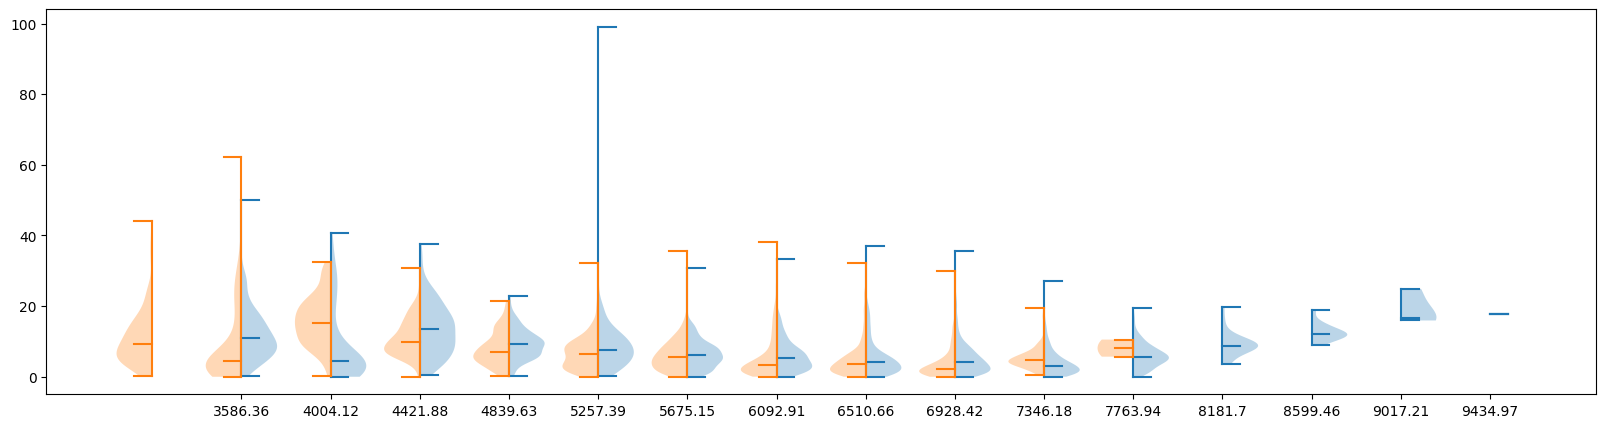

In [14]:
plt.figure(figsize=(20,5))
kwargs = {'showextrema':True, 
            'showmedians':True,
          'widths':0.8,
         # 'bw_method':'silverman'
         }
plt.violinplot(dataset=binned_rnn, points=int(1e4), side='high', **kwargs)
plt.violinplot(dataset=binned_rf, positions=indices_rf, points=int(1e4), side='low', **kwargs)

plt.xticks(ticks=range(1, len(mid_bins)+1), labels=centers, rotation=0)
# plt.legend(loc=0)
plt.show()

In [15]:
rnn_output

,True_T_eff,mean_T_eff,median_T_eff,p_diff
84300158481827892,7396.3037,7350.774300,7285.7590,1.494594
74163190788076994,5955.7760,6142.597514,6164.4080,3.503020
103253008374854869,6638.7150,5752.894414,5754.9253,13.312662
74022884304620926,7203.6280,6681.255014,6691.5337,7.108839
131542740608734400,6253.8680,5833.205900,5885.1260,5.896223
...,...,...,...,...
119763092193972840,7193.5400,7146.388471,7192.1330,0.019559
101412581530053985,4935.4830,5469.679943,5404.7790,9.508613
88030993986271827,5179.1553,5918.940929,5910.0730,14.112682
98612894834983456,5699.5474,5611.434000,5629.2485,1.233412
